In [68]:
import os
import pandas as pd
from typing import List, Dict
import pandas as pd
import glob
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import os

dataset_dirs = ["04_datasets/power_7b", "04_datasets/power_6b"]#, "04_datasets/power_5b", "04_datasets/power_4"]
test_dataset_dirs = ["04_datasets/power_7c", "04_datasets/power_7b"]
time_limit = 600
autogluon_preset = "medium"
label_column = "target"
model_save_dir = "saved_models/6b_7b_10min"
dataset_types = ["CPU.feather",
                 "Disk_io.feather",
                 "Kepler.feather",
                 "Memory.feather",
                 "Network.feather",
                 "Other.feather"
                 ]

class Dataset:
    def __init__(self, training_df: pd.DataFrame, testing_dfs: dict[str, pd.DataFrame], label: str):
        self.training_df = training_df  # Just the full training df
        self.testing_dfs = testing_dfs  # name-df pairs for measuring against multiple targets
        self.label = label  # Extra label for plotting

def get_datasets(train_file_paths: List[str], test_file_paths: List[str], label) -> Dataset:
    train_df_list = []
    for train_file_path in train_file_paths:
        train_df = pd.read_feather(train_file_path)
        train_df = train_df.dropna()  # Drop NaN values
        train_df_list.append(train_df)
    train_df = pd.concat(train_df_list, axis=0)


    # Load the testing datasets
    test_df_dict = {}
    for test_file_path in test_file_paths:
        test_df = pd.read_feather(test_file_path)
        test_df = test_df.dropna()  # Drop NaN values
        name = os.path.basename(os.path.dirname(test_file_path))
        test_df_dict[name] = test_df

    # Scale to account for 5 second sampling rate (TODO: Should do this when creating the dataset)
    train_df["target"] = train_df["target"] / 5
    for test_df in test_df_dict.values():
        test_df["target"] = test_df["target"] / 5

    # Check common columns
    common_cols = set(train_df.columns)
    for test_df in test_df_dict.values():
        common_cols = common_cols.intersection(set(test_df.columns))
    common_cols = list(common_cols)
    print(f"Train dataset has {[len(train_df.columns) for train_df in train_df_list]} columns")
    print(f"Test datasets has {[len(test_df.columns) for test_df in test_df_dict.values()]} columns")
    print(f"Using {len(common_cols)} common columns for training and testing")

    # Filter all datasets to only include common columns
    train_df = train_df[common_cols]
    for key in test_df_dict.keys():
        test_df_dict[key] = test_df_dict[key][common_cols]

    return Dataset(train_df, test_df_dict, label)

datasets = {}
# Add datasets from multiple paths
for dataset_type in dataset_types:
    name = dataset_type
    label = "6b and 7b"
    print(f"\nLoading {name}...")
    training_files = [os.path.join(p, dataset_type) for p in dataset_dirs]
    testing_files = [os.path.join(p, dataset_type) for p in test_dataset_dirs]
    datasets[name] = get_datasets(training_files, testing_files, label)

# Additionally, train on solo datasets
partial_path = "04_datasets/power_"
for dataset_postfix in ["6b", "7b", "7c"]:
    for dataset_type in dataset_types:
        name = f"{dataset_type}_{dataset_postfix}"
        label = dataset_postfix
        print(f"\nLoading {name}...")
        train_path = f"{partial_path}{dataset_postfix}"
        training_files = [os.path.join(train_path, dataset_type)]
        testing_files = [os.path.join(p, dataset_type) for p in test_dataset_dirs]
        datasets[name] = get_datasets(training_files, testing_files, label)


Loading CPU.feather...
Train dataset has [54, 54] columns
Test datasets has [54, 54] columns
Using 54 common columns for training and testing

Loading Disk_io.feather...
Train dataset has [14, 11] columns
Test datasets has [15, 14] columns
Using 14 common columns for training and testing

Loading Kepler.feather...
Train dataset has [1, 1] columns
Test datasets has [1, 1] columns
Using 1 common columns for training and testing

Loading Memory.feather...
Train dataset has [10, 4] columns
Test datasets has [10, 10] columns
Using 10 common columns for training and testing

Loading Network.feather...
Train dataset has [26, 32] columns
Test datasets has [26, 26] columns
Using 26 common columns for training and testing

Loading Other.feather...
Train dataset has [15, 10] columns
Test datasets has [15, 15] columns
Using 15 common columns for training and testing

Loading CPU.feather_6b...
Train dataset has [54] columns
Test datasets has [54, 54] columns
Using 54 common columns for training an

In [69]:
""" Training code """

class DatasetModelEval:
    def __init__(self, dataset: Dataset, model: TabularPredictor, evaluation):
        self.model = model
        self.dataset = dataset
        self.evaluation = evaluation
        self.label = dataset.label

def train_or_load(save_path: str, train_df: pd.DataFrame, time_limit: int, autogluon_preset: str = "medium"):
    if os.path.exists(save_path):
        print(f"Found existing model for {save_path}, loading...")
        predictor = TabularPredictor.load(save_path)
    else:
        print(f"Training new model for {save_path}...")
        predictor = TabularPredictor(label=label_column, problem_type="regression", path=save_path)
        predictor.fit(train_df, time_limit=time_limit,
                      verbosity=2, presets=autogluon_preset)
    return predictor

model_containers = {}
for name, dataset in datasets.items():
    try:
        save_path = os.path.join(model_save_dir, name)
        predictor = train_or_load(save_path, dataset.training_df, time_limit, autogluon_preset)
        model_containers[name] = DatasetModelEval(dataset, predictor, None)
    except Exception as e:
        print(f"Error occurred while training {name}: {e}")
print("Done")

Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
Memory Avail:       34.90 GB / 63.77 GB (54.7%)
Disk Space Avail:   110.78 GB / 1906.83 GB (5.8%)
Presets specified: ['medium']
Beginning AutoGluon training ... Time limit = 600s


Found existing model for saved_models/6b_7b_10min\CPU.feather, loading...
Found existing model for saved_models/6b_7b_10min\Disk_io.feather, loading...
Found existing model for saved_models/6b_7b_10min\Kepler.feather, loading...
Found existing model for saved_models/6b_7b_10min\Memory.feather, loading...
Found existing model for saved_models/6b_7b_10min\Network.feather, loading...
Found existing model for saved_models/6b_7b_10min\Other.feather, loading...
Training new model for saved_models/6b_7b_10min\CPU.feather_6b...


AutoGluon will save models to "C:\Users\Anton\Documents\projektit\06_framework\framework-predict\experiments\energy\saved_models\6b_7b_10min\CPU.feather_6b"
Train Data Rows:    97190
Train Data Columns: 53
Label Column:       target
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    35734.38 MB
	Train Data (Original)  Memory Usage: 39.30 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dty

[1000]	valid_set's rmse: 11.0761
[2000]	valid_set's rmse: 10.5435
[3000]	valid_set's rmse: 10.1884
[4000]	valid_set's rmse: 9.95149
[5000]	valid_set's rmse: 9.74835
[6000]	valid_set's rmse: 9.56854
[7000]	valid_set's rmse: 9.42412
[8000]	valid_set's rmse: 9.27687
[9000]	valid_set's rmse: 9.16847
[10000]	valid_set's rmse: 9.05473


	-9.0546	 = Validation score   (-root_mean_squared_error)
	17.49s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 580.80s of the 580.80s of remaining time.


[1000]	valid_set's rmse: 9.93946
[2000]	valid_set's rmse: 9.02812
[3000]	valid_set's rmse: 8.49639
[4000]	valid_set's rmse: 8.09994
[5000]	valid_set's rmse: 7.84406
[6000]	valid_set's rmse: 7.62663
[7000]	valid_set's rmse: 7.4602
[8000]	valid_set's rmse: 7.3353
[9000]	valid_set's rmse: 7.22835
[10000]	valid_set's rmse: 7.14593


	-7.1459	 = Validation score   (-root_mean_squared_error)
	15.01s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 564.92s of the 564.91s of remaining time.
	-7.9454	 = Validation score   (-root_mean_squared_error)
	23.18s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 541.30s of the 541.30s of remaining time.
	-8.384	 = Validation score   (-root_mean_squared_error)
	89.73s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 451.54s of the 451.54s of remaining time.
	-8.2779	 = Validation score   (-root_mean_squared_error)
	5.76s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 445.38s of the 445.37s of remaining time.
	-10.615	 = Validation score   (-root_mean_squared_error)
	58.61s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGB

Training new model for saved_models/6b_7b_10min\Disk_io.feather_6b...


	-18.0374	 = Validation score   (-root_mean_squared_error)
	0.17s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 599.67s of the 599.67s of remaining time.
	-15.081	 = Validation score   (-root_mean_squared_error)
	0.17s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 599.46s of the 599.46s of remaining time.


[1000]	valid_set's rmse: 20.9323
[2000]	valid_set's rmse: 20.8016
[3000]	valid_set's rmse: 20.7393
[4000]	valid_set's rmse: 20.709
[5000]	valid_set's rmse: 20.6742
[6000]	valid_set's rmse: 20.6357
[7000]	valid_set's rmse: 20.6115
[8000]	valid_set's rmse: 20.592
[9000]	valid_set's rmse: 20.5746
[10000]	valid_set's rmse: 20.5607


	-20.5575	 = Validation score   (-root_mean_squared_error)
	9.54s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 589.09s of the 589.09s of remaining time.


[1000]	valid_set's rmse: 19.2549
[2000]	valid_set's rmse: 18.4895
[3000]	valid_set's rmse: 18.0194
[4000]	valid_set's rmse: 17.6353
[5000]	valid_set's rmse: 17.4019
[6000]	valid_set's rmse: 17.1607
[7000]	valid_set's rmse: 16.9797
[8000]	valid_set's rmse: 16.8188
[9000]	valid_set's rmse: 16.6473
[10000]	valid_set's rmse: 16.5048


	-16.5048	 = Validation score   (-root_mean_squared_error)
	7.73s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 580.53s of the 580.53s of remaining time.
	-11.0906	 = Validation score   (-root_mean_squared_error)
	4.39s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 575.72s of the 575.72s of remaining time.
	-18.9887	 = Validation score   (-root_mean_squared_error)
	81.15s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 494.54s of the 494.54s of remaining time.
	-13.6686	 = Validation score   (-root_mean_squared_error)
	1.42s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 492.70s of the 492.70s of remaining time.
	-21.6462	 = Validation score   (-root_mean_squared_error)
	54.84s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model:

Training new model for saved_models/6b_7b_10min\Kepler.feather_6b...


Fitting model: KNeighborsDist ... Training model for up to 599.69s of the 599.69s of remaining time.
	No valid features to train KNeighborsDist... Skipping this model.
Fitting model: LightGBMXT ... Training model for up to 599.44s of the 599.43s of remaining time.
	No valid features to train LightGBMXT... Skipping this model.
Fitting model: LightGBM ... Training model for up to 599.17s of the 599.17s of remaining time.
	No valid features to train LightGBM... Skipping this model.
Fitting model: RandomForestMSE ... Training model for up to 598.91s of the 598.91s of remaining time.
	No valid features to train RandomForestMSE... Skipping this model.
Fitting model: CatBoost ... Training model for up to 598.66s of the 598.65s of remaining time.
	No valid features to train CatBoost... Skipping this model.
Fitting model: ExtraTreesMSE ... Training model for up to 598.39s of the 598.39s of remaining time.
	No valid features to train ExtraTreesMSE... Skipping this model.
Fitting model: NeuralNet

Error occurred while training Kepler.feather_6b: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.
Training new model for saved_models/6b_7b_10min\Memory.feather_6b...


	-17.8453	 = Validation score   (-root_mean_squared_error)
	0.07s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 599.82s of the 599.82s of remaining time.
	-14.6772	 = Validation score   (-root_mean_squared_error)
	0.07s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 599.71s of the 599.71s of remaining time.


[1000]	valid_set's rmse: 21.4024
[2000]	valid_set's rmse: 21.2269
[3000]	valid_set's rmse: 21.1747
[4000]	valid_set's rmse: 21.1297
[5000]	valid_set's rmse: 21.1144
[6000]	valid_set's rmse: 21.11
[7000]	valid_set's rmse: 21.0975
[8000]	valid_set's rmse: 21.087
[9000]	valid_set's rmse: 21.079
[10000]	valid_set's rmse: 21.0749


	-21.0748	 = Validation score   (-root_mean_squared_error)
	9.64s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 589.27s of the 589.27s of remaining time.
	-21.0158	 = Validation score   (-root_mean_squared_error)
	0.72s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 588.51s of the 588.51s of remaining time.
	-11.4715	 = Validation score   (-root_mean_squared_error)
	2.43s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 585.67s of the 585.67s of remaining time.
	-21.0496	 = Validation score   (-root_mean_squared_error)
	9.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 576.55s of the 576.55s of remaining time.
	-14.7772	 = Validation score   (-root_mean_squared_error)
	1.07s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNet

Training new model for saved_models/6b_7b_10min\Network.feather_6b...


Fitting model: KNeighborsUnif ... Training model for up to 599.85s of the 599.85s of remaining time.
	-14.9722	 = Validation score   (-root_mean_squared_error)
	0.04s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 599.72s of the 599.72s of remaining time.
	-12.9772	 = Validation score   (-root_mean_squared_error)
	0.05s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 599.60s of the 599.60s of remaining time.


[1000]	valid_set's rmse: 17.1068
[2000]	valid_set's rmse: 16.6548
[3000]	valid_set's rmse: 16.3698
[4000]	valid_set's rmse: 16.1782
[5000]	valid_set's rmse: 16.0288
[6000]	valid_set's rmse: 15.9008
[7000]	valid_set's rmse: 15.7979
[8000]	valid_set's rmse: 15.7189
[9000]	valid_set's rmse: 15.6435
[10000]	valid_set's rmse: 15.5698


	-15.5695	 = Validation score   (-root_mean_squared_error)
	12.82s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 585.92s of the 585.92s of remaining time.


[1000]	valid_set's rmse: 14.4296
[2000]	valid_set's rmse: 13.8416
[3000]	valid_set's rmse: 13.4723
[4000]	valid_set's rmse: 13.251
[5000]	valid_set's rmse: 13.1277
[6000]	valid_set's rmse: 13.0176
[7000]	valid_set's rmse: 12.9112
[8000]	valid_set's rmse: 12.7828
[9000]	valid_set's rmse: 12.7026
[10000]	valid_set's rmse: 12.6439


	-12.6427	 = Validation score   (-root_mean_squared_error)
	9.03s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 576.06s of the 576.06s of remaining time.
	-9.7148	 = Validation score   (-root_mean_squared_error)
	7.03s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 568.64s of the 568.64s of remaining time.
	-13.531	 = Validation score   (-root_mean_squared_error)
	79.27s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 489.34s of the 489.34s of remaining time.
	-9.7334	 = Validation score   (-root_mean_squared_error)
	1.94s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 487.01s of the 487.01s of remaining time.
	-15.2721	 = Validation score   (-root_mean_squared_error)
	55.31s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XG

Training new model for saved_models/6b_7b_10min\Other.feather_6b...


	-18.9612	 = Validation score   (-root_mean_squared_error)
	0.15s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 599.68s of the 599.68s of remaining time.
	-19.0062	 = Validation score   (-root_mean_squared_error)
	0.15s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBMXT ... Training model for up to 599.46s of the 599.45s of remaining time.


[1000]	valid_set's rmse: 17.2919
[2000]	valid_set's rmse: 17.1176
[3000]	valid_set's rmse: 17.06
[4000]	valid_set's rmse: 17.0338
[5000]	valid_set's rmse: 17.0167
[6000]	valid_set's rmse: 17.0059
[7000]	valid_set's rmse: 16.9945
[8000]	valid_set's rmse: 16.9903
[9000]	valid_set's rmse: 16.9844
[10000]	valid_set's rmse: 16.9791


	-16.9786	 = Validation score   (-root_mean_squared_error)
	9.4s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 589.22s of the 589.22s of remaining time.


[1000]	valid_set's rmse: 16.9056
[2000]	valid_set's rmse: 16.8788
[3000]	valid_set's rmse: 16.8674
[4000]	valid_set's rmse: 16.8675


	-16.8643	 = Validation score   (-root_mean_squared_error)
	3.41s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 585.53s of the 585.53s of remaining time.
	-17.1111	 = Validation score   (-root_mean_squared_error)
	3.3s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 581.82s of the 581.82s of remaining time.
	-16.8502	 = Validation score   (-root_mean_squared_error)
	63.82s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 517.98s of the 517.97s of remaining time.
	-16.8837	 = Validation score   (-root_mean_squared_error)
	1.35s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ... Training model for up to 516.19s of the 516.19s of remaining time.
	-17.5392	 = Validation score   (-root_mean_squared_error)
	57.31s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: X

Found existing model for saved_models/6b_7b_10min\CPU.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\Disk_io.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\Kepler.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\Memory.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\Network.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\Other.feather_7b, loading...
Found existing model for saved_models/6b_7b_10min\CPU.feather_7c, loading...
Found existing model for saved_models/6b_7b_10min\Disk_io.feather_7c, loading...
Found existing model for saved_models/6b_7b_10min\Kepler.feather_7c, loading...
Found existing model for saved_models/6b_7b_10min\Memory.feather_7c, loading...
Found existing model for saved_models/6b_7b_10min\Network.feather_7c, loading...
Found existing model for saved_models/6b_7b_10min\Other.feather_7c, loading...
Done


No model for Kepler.feather, skipping...
No model for Kepler.feather_7b, skipping...
No model for Kepler.feather_7c, skipping...


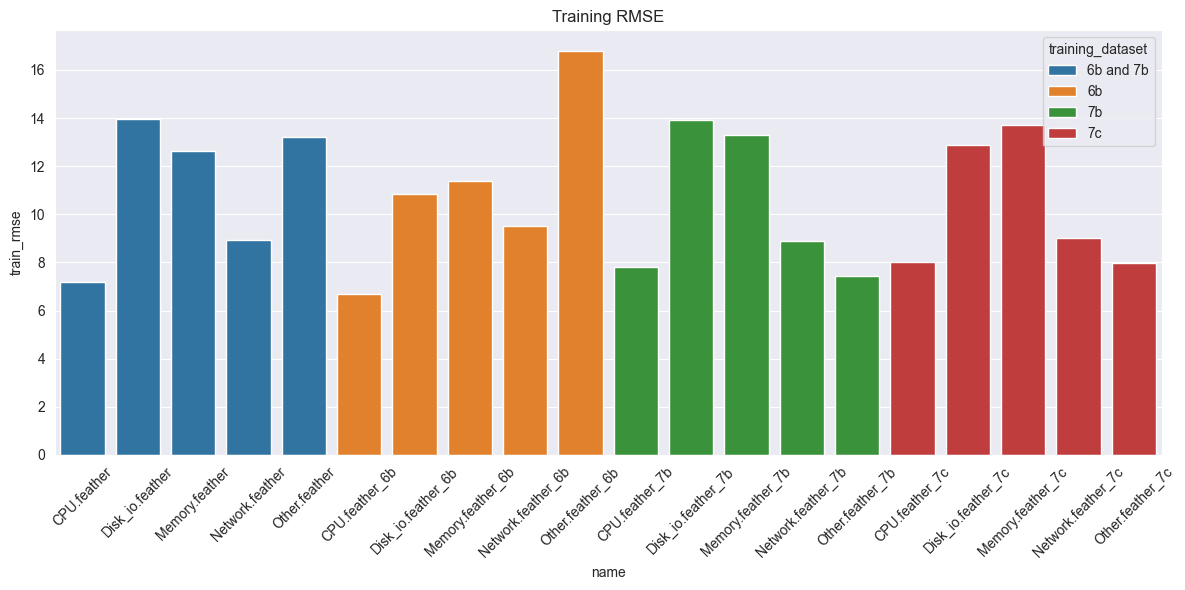

In [70]:
""" Plotting training results """
def plot_training_results(model_containers: Dict[str, DatasetModelEval]):
    results_list = []
    for model_name, model_container in model_containers.items():
        if len(model_container.model.leaderboard()) == 0:
            print(f"No model for {model_name}, skipping...")
            continue
        predictor = model_container.model
        results_dict = {}
        results_dict["name"] = model_name
        results_dict["training_dataset"] = model_container.label
        results_dict["train_rmse"] = -predictor.leaderboard(silent=True)['score_val'][0]
        results_list.append(results_dict)
    summary_df = pd.DataFrame(results_list)

    # Plot training performance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=summary_df, x="name", y="train_rmse", hue="training_dataset")
    plt.title("Training RMSE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_training_results(model_containers)

Evaluating CPU.feather...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Disk_io.feather...
	Evaluating against power_7c...
	Evaluating against power_7b...
No model for Kepler.feather, skipping...
Evaluating Memory.feather...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Network.feather...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Other.feather...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating CPU.feather_6b...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Disk_io.feather_6b...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Memory.feather_6b...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Network.feather_6b...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating Other.feather_6b...
	Evaluating against power_7c...
	Evaluating against power_7b...
Evaluating CPU.fea

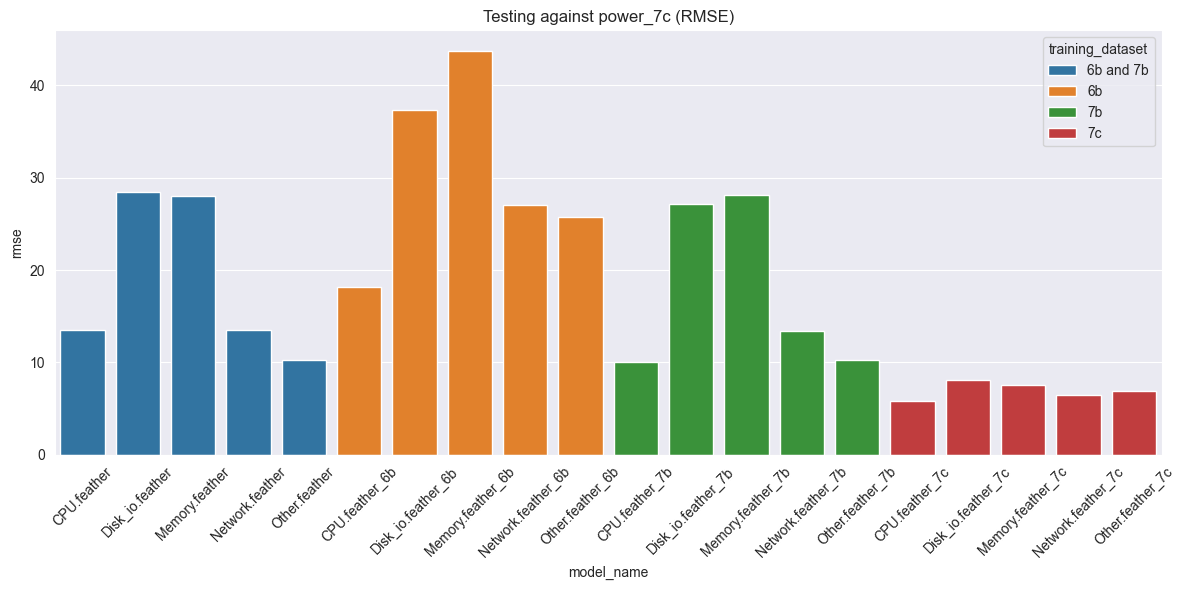

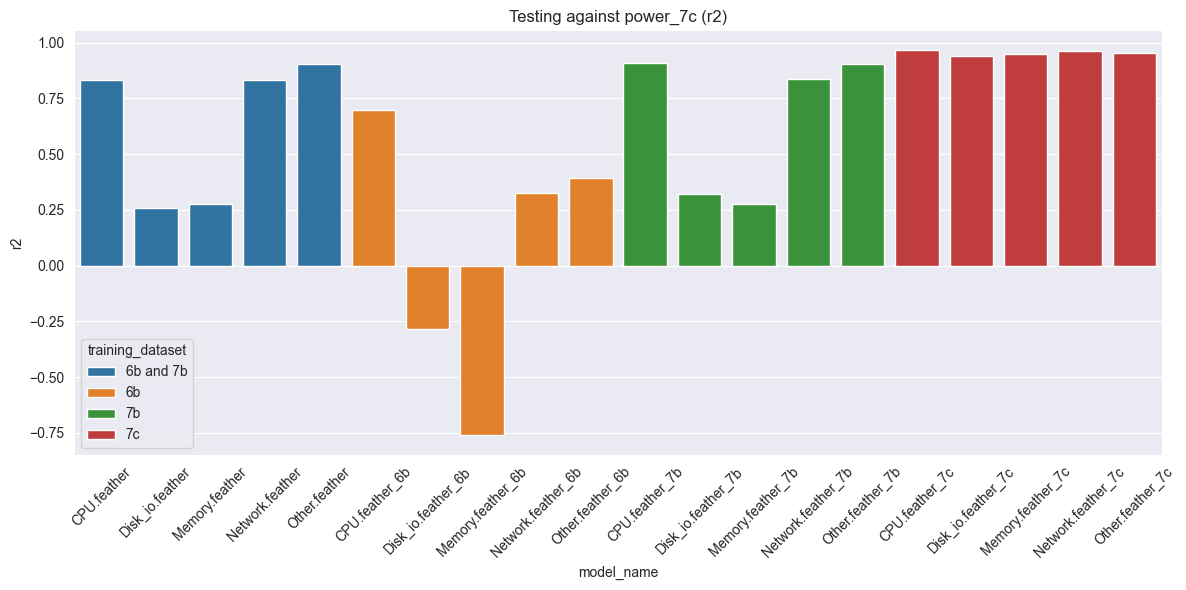

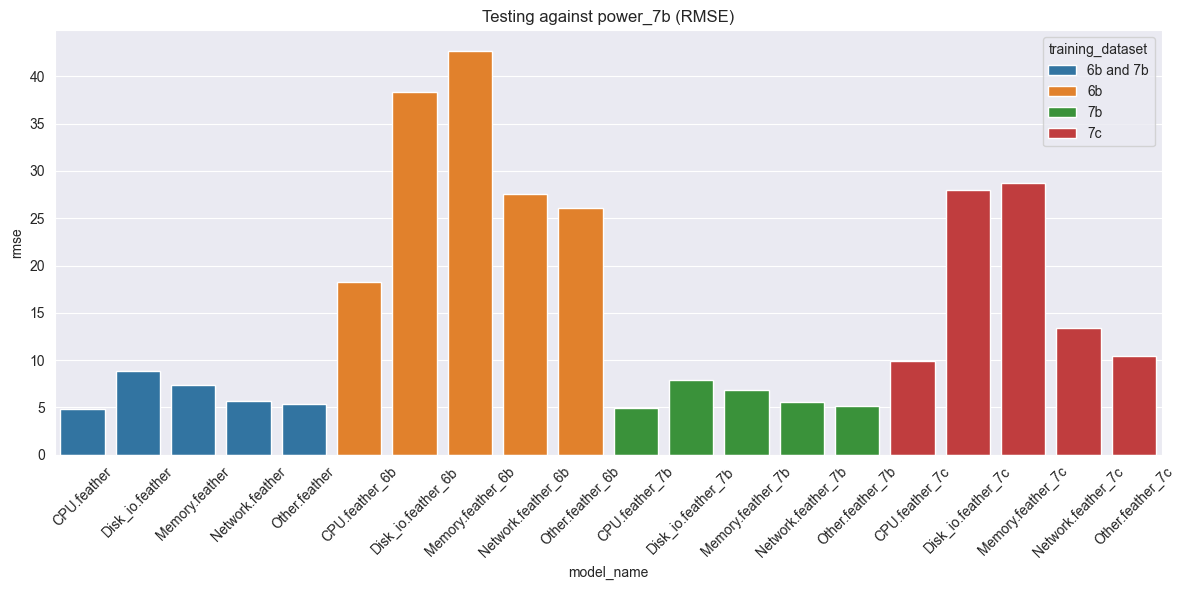

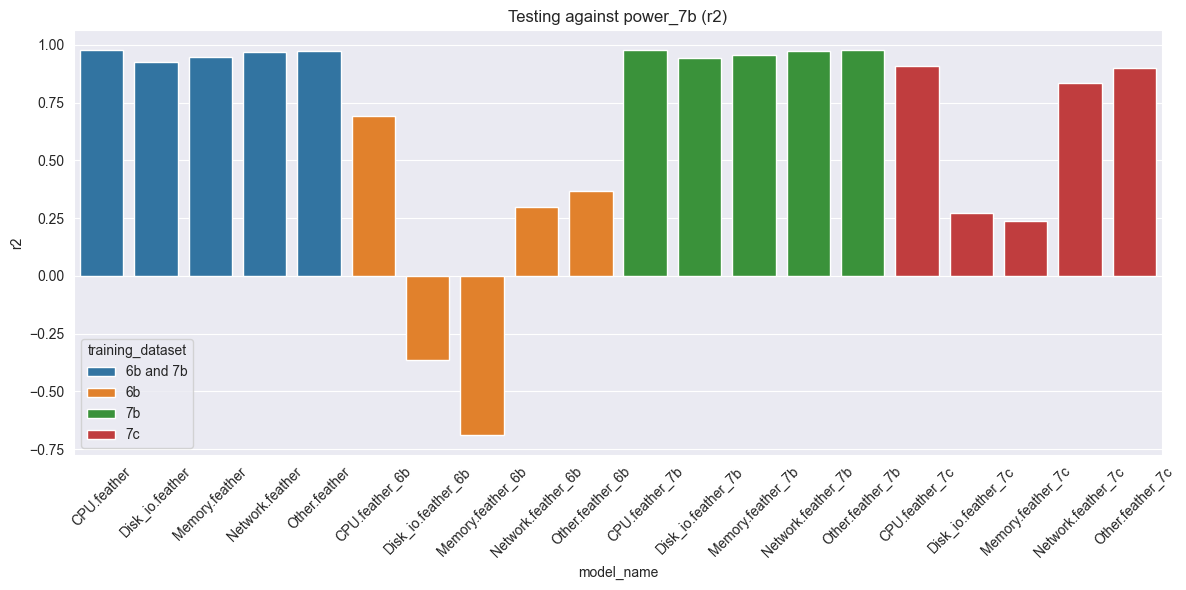

In [71]:
""" Plotting evaluation results """
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_models(models: Dict[str, DatasetModelEval]):
    # Evaluate all models against all test datasets
    for model_name, model_container in models.items():
        if len(model_container.model.leaderboard()) == 0:
            print(f"No model for {model_name}, skipping...")
            continue
        print(f"Evaluating {model_name}...")
        evaluate_model(model_container)

def evaluate_model(model_container: DatasetModelEval):
    if model_container.evaluation is None:
        model_container.evaluation = {}

    # Evaluate against all test datasets
    for test_name, test_df in model_container.dataset.testing_dfs.items():
        # Run predictions on the test dataset
        if test_name in model_container.evaluation:
            print(f"\tSkipping {test_name} because it was already evaluated...")
            continue
        print(f"\tEvaluating against {test_name}...")
        predictor = model_container.model
        y_pred = predictor.predict(test_df.drop(columns=[label_column]))
        y_true = test_df[label_column]
        test_mse = mean_squared_error(y_true, y_pred)
        test_rmse = test_mse**0.5
        test_r2 = r2_score(y_true, y_pred)

        # Add results
        model_container.evaluation[test_name] = {"mse": test_mse, "rmse": test_rmse, "r2": test_r2}

def plot_evaluation_results(model_containers: Dict[str, DatasetModelEval]):
    results = {}
    for model_name, model_container in model_containers.items():
        if model_container.evaluation is None:
            # No model or no eval results
            continue
        for test_name, test_results in model_container.evaluation.items():
            results_dict = {}
            results_dict["model_name"] = model_name
            results_dict["training_dataset"] = model_container.label
            results_dict["mse"] = test_results["mse"]
            results_dict["rmse"] = test_results["rmse"]
            results_dict["r2"] = test_results["r2"]
            if test_name not in results:
                results[test_name] = []
            results[test_name].append(results_dict)

    for test_name, results_list in results.items():
        summary_df = pd.DataFrame(results_list)

        # Plot training performance
        plt.figure(figsize=(12, 6))
        sns.barplot(data=summary_df, x="model_name", y="rmse", hue="training_dataset")
        plt.title(f"Testing against {test_name} (RMSE)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.barplot(data=summary_df, x="model_name", y="r2", hue="training_dataset")
        plt.title(f"Testing against {test_name} (r2)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

evaluate_models(model_containers)
plot_evaluation_results(model_containers)
